In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Create dataset
Use Sam to extract proposals from input images (100 images) then for proposals with same regions as the ground truth masks, they are considered as positive sameple to the templates ( use the BlenderProc 42 templates), negative otherwise

Run through 100 images - then return positive proposals and negative proposals

Use IoU >0.5 to get the postive proposals

## 1.1 Extract positive proposals (the same ones as gt mask)

In [10]:
# from src.model.constrastive_learning import extract_dataset

# dataset="icbin"
# data_type="test"
# scene_id=1
# pos_proposals, neg_proposals = extract_dataset(dataset, data_type, scene_id) # Take 2.21 minutes

In [6]:
# all_pos_proposals = [item for sublist in pos_proposals for item in sublist]
# all_neg_proposals = [item for sublist in neg_proposals for item in sublist]

In [8]:
# import pickle

# with open('contrastive_learning/all_pos_proposals.pkl', 'wb') as file:
#     pickle.dump(all_pos_proposals, file)

# with open('contrastive_learning/all_neg_proposals.pkl', 'wb') as file:
#     pickle.dump(all_neg_proposals, file)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle


with open('contrastive_learning/all_pos_proposals.pkl', 'rb') as file:
    pos = pickle.load(file)

with open('contrastive_learning/all_neg_proposals.pkl', 'rb') as file:
    neg = pickle.load(file)

## 1.2 Create psotive and neagtive pairs
Positive pairs (positive proposal and template with most similar pose)

In [3]:
import os
os.environ['PYDEVD_WARN_EVALUATION_TIMEOUT'] = '10'
os.environ['PYDEVD_UNBLOCK_THREADS_TIMEOUT'] = '5'

In [4]:
import torch

from src.model.constrastive_learning import ContrastiveModel


template_paths = "datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_000001/*.png"
template_poses_path = "datasets/bop23_challenge/datasets/templates_pyrender/icbin/template_poses.npy"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ContrastiveModel(device)
model.load_state_dict(torch.load("contrastive_learning/saved_checkpoints/best_model_checkpoint.pth"))


Using cache found in /home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
[2024-08-15 15:30:32,765] [INFO] dinov2: using MLP layer as FFN


<All keys matched successfully>

In [7]:
from src.model.constrastive_learning import train

train(device = device, model= model, template_paths=template_paths, template_poses_path=template_poses_path,
    all_pos_proposals=pos, all_neg_proposals=neg, num_epochs=50)

# 3. Test

Using cache found in /home/cuong.van-dam/.cache/torch/hub/facebookresearch_dinov2_main
[2024-08-15 15:07:13,907] [INFO] dinov2: using MLP layer as FFN


Dissimilarity score: tensor([0.5652])


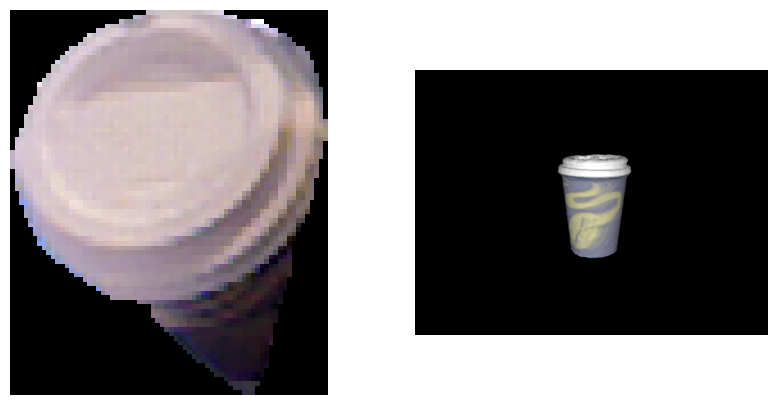

Dissimilarity score: tensor([0.0794])


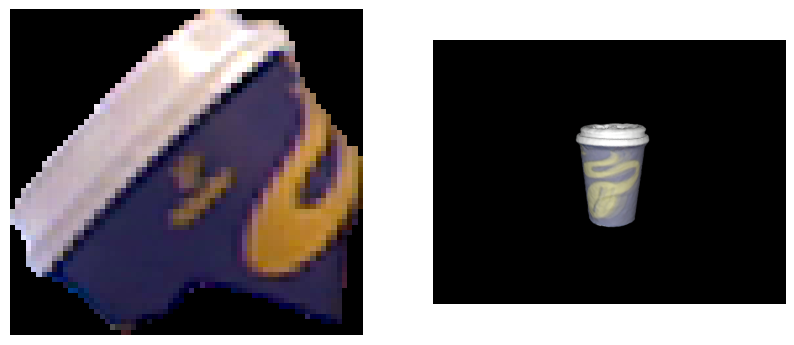

Dissimilarity score: tensor([0.5093])


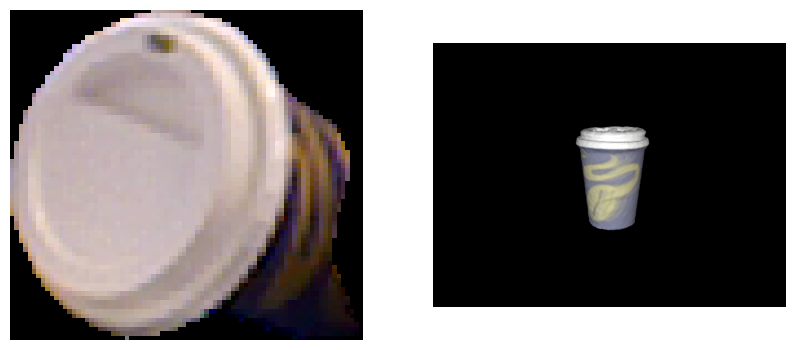

Dissimilarity score: tensor([0.1630])


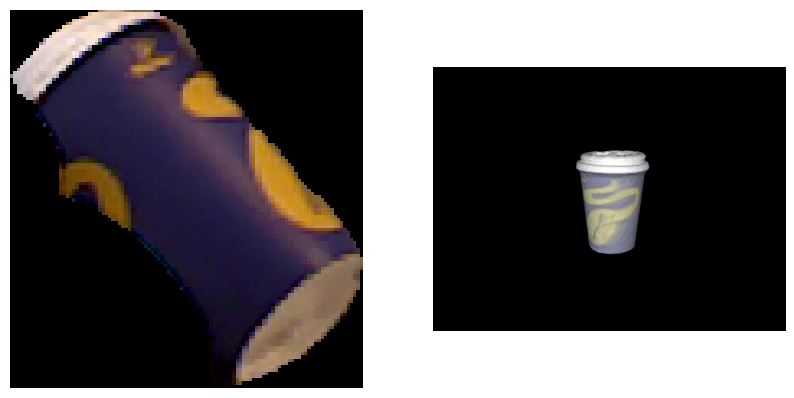

Dissimilarity score: tensor([0.1123])


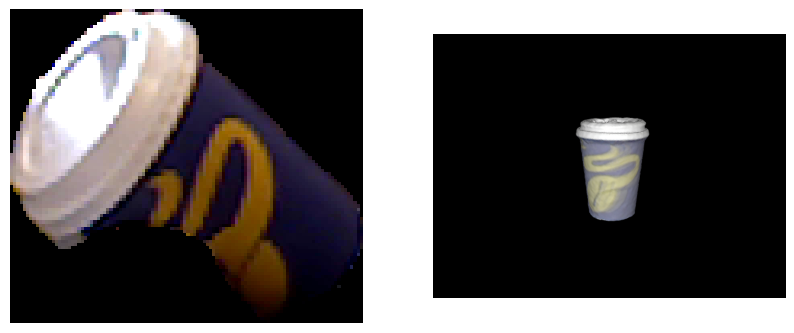

Dissimilarity score: tensor([0.2087])


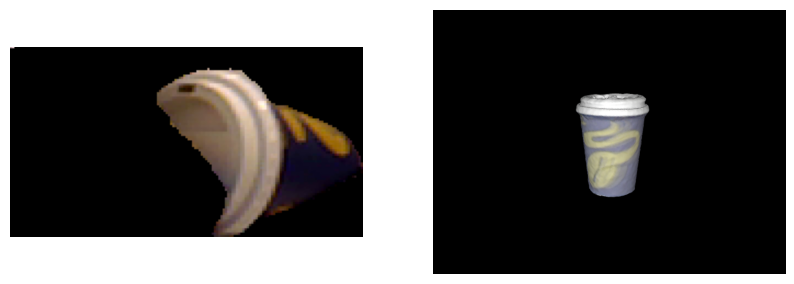

Dissimilarity score: tensor([0.4769])


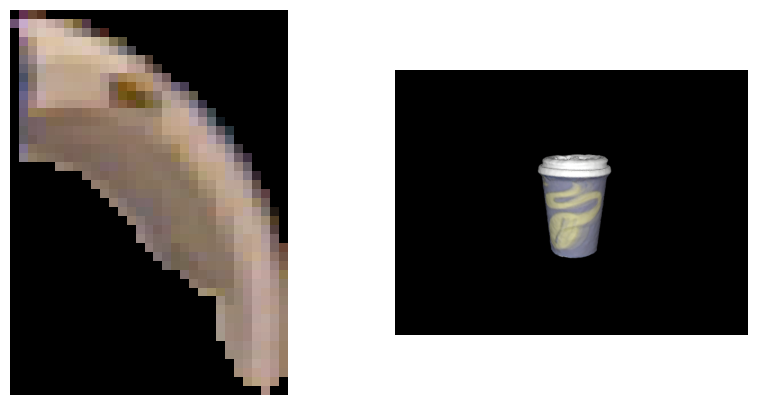

Dissimilarity score: tensor([0.1190])


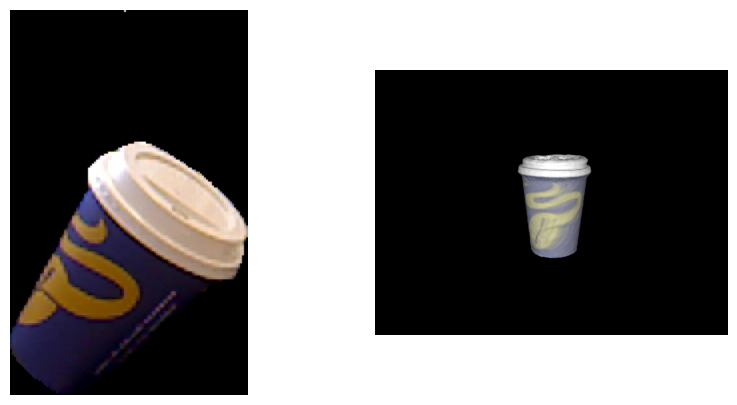

Dissimilarity score: tensor([0.2273])


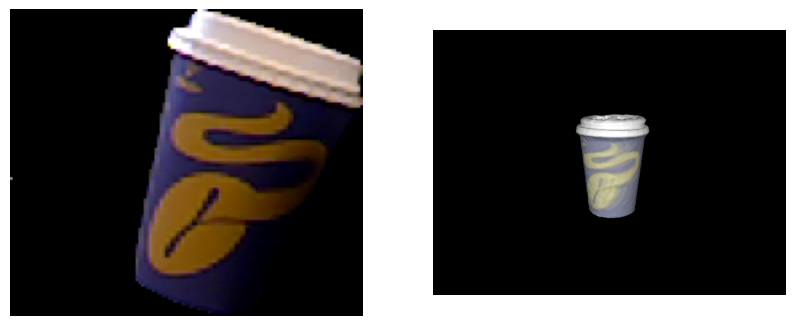

Dissimilarity score: tensor([0.1079])


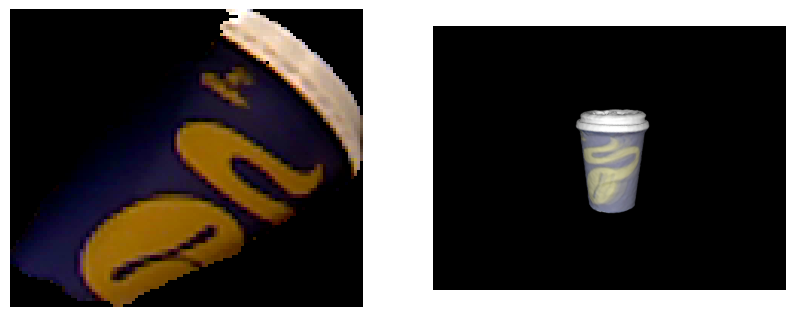

Dissimilarity score: tensor([0.5928])


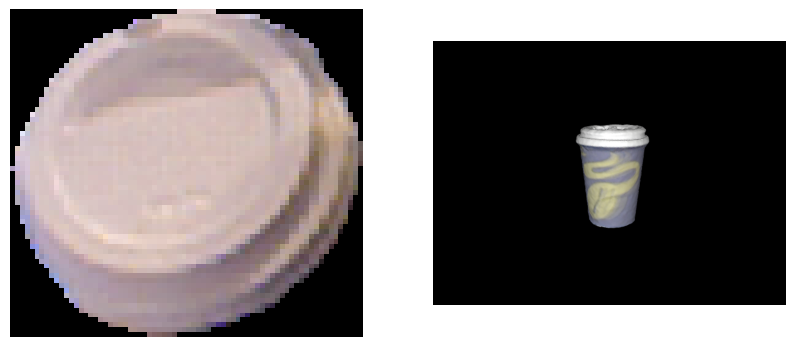

Dissimilarity score: tensor([0.0633])


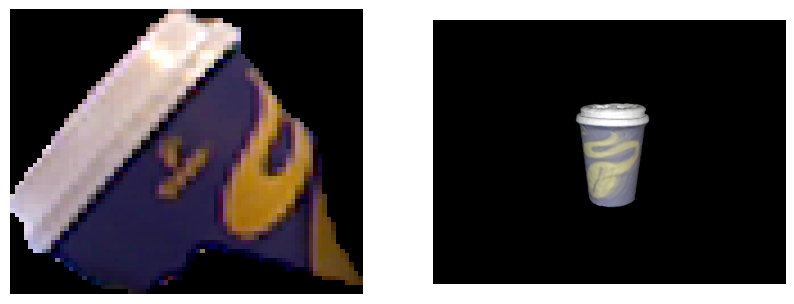

Dissimilarity score: tensor([0.5651])


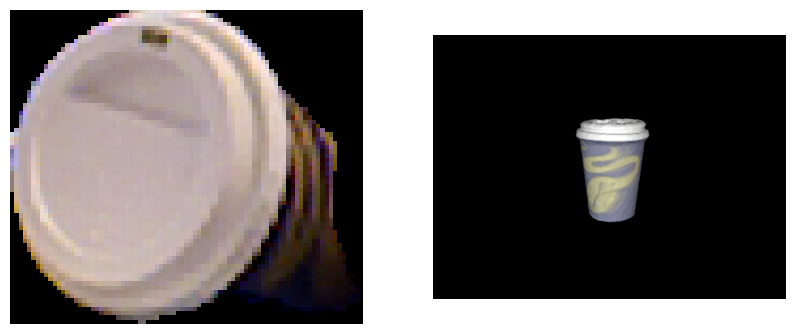

Dissimilarity score: tensor([0.3503])


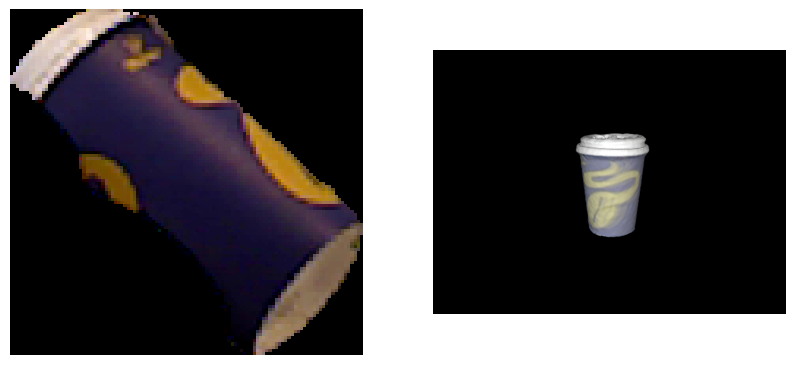

Dissimilarity score: tensor([0.1626])


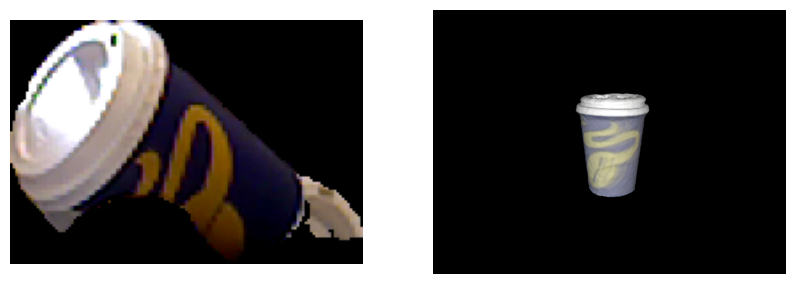

Dissimilarity score: tensor([0.2978])


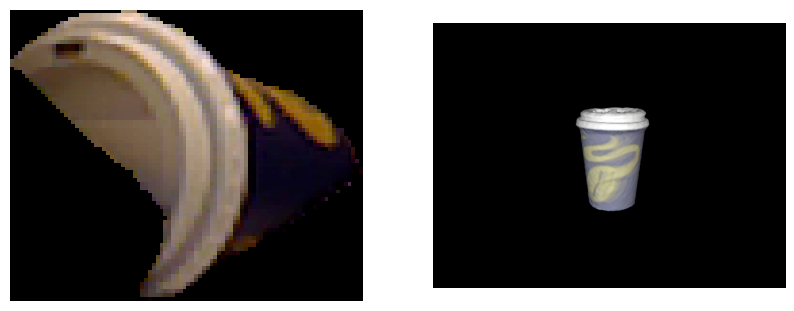

Dissimilarity score: tensor([0.5100])


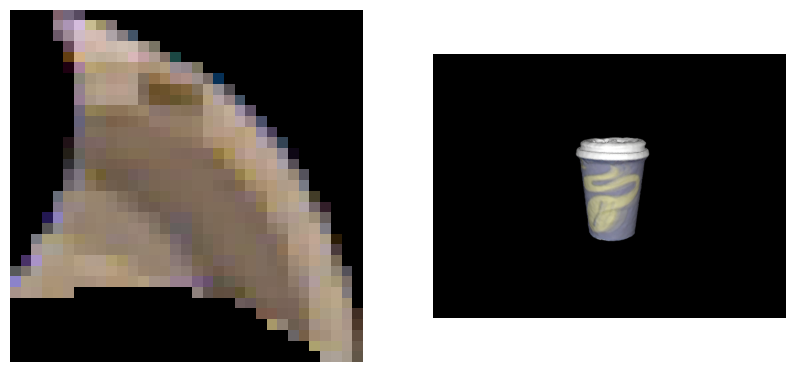

Dissimilarity score: tensor([0.2445])


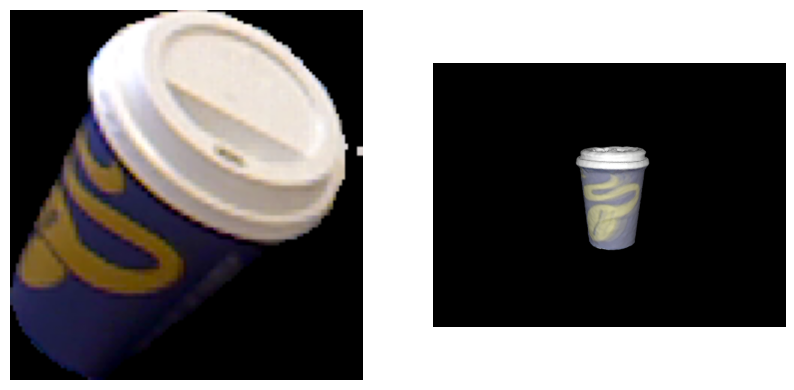

Dissimilarity score: tensor([0.1951])


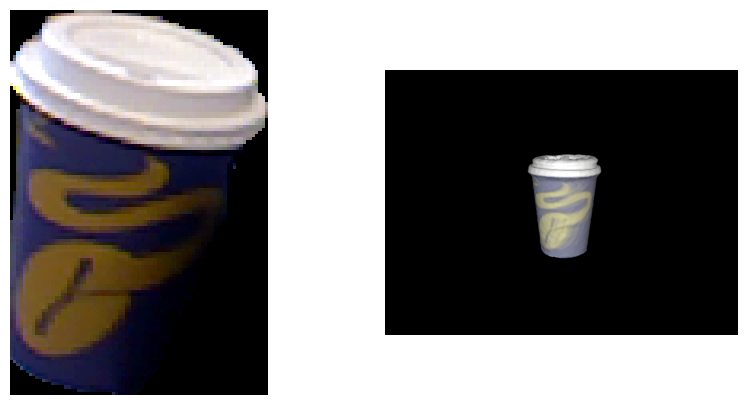

Dissimilarity score: tensor([0.1151])


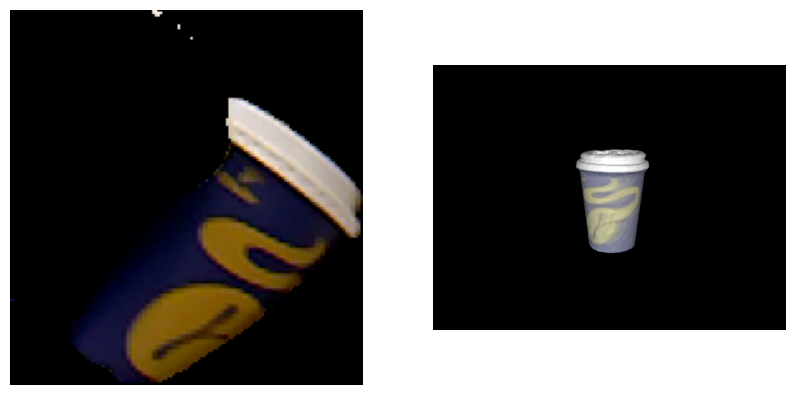

Dissimilarity score: tensor([0.6870])


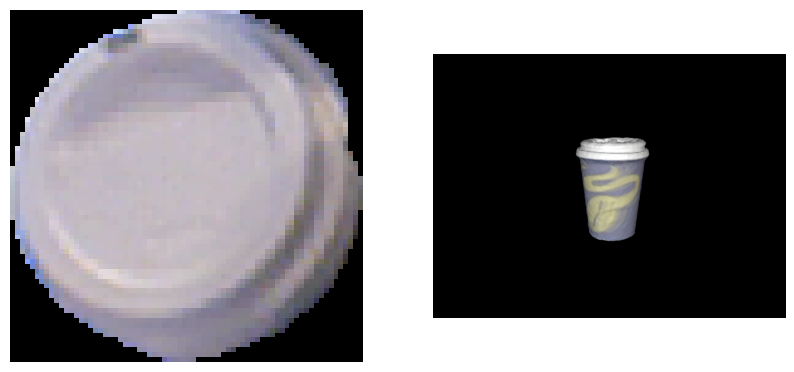

Dissimilarity score: tensor([0.0680])


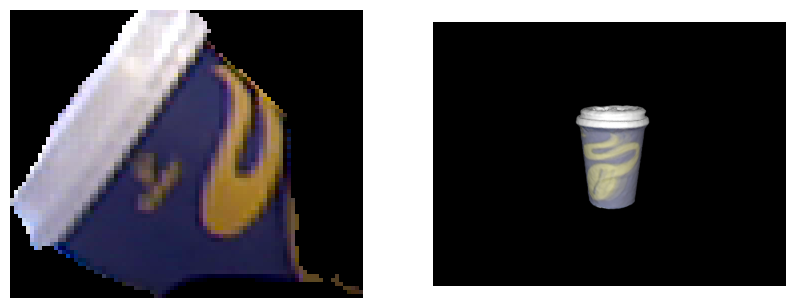

Dissimilarity score: tensor([0.6684])


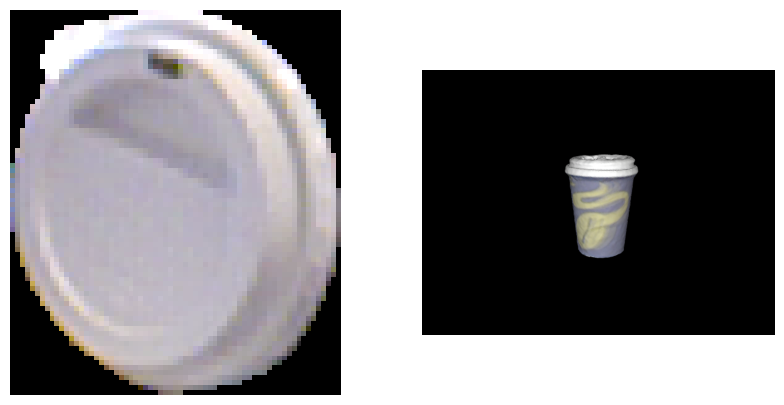

Dissimilarity score: tensor([0.2263])


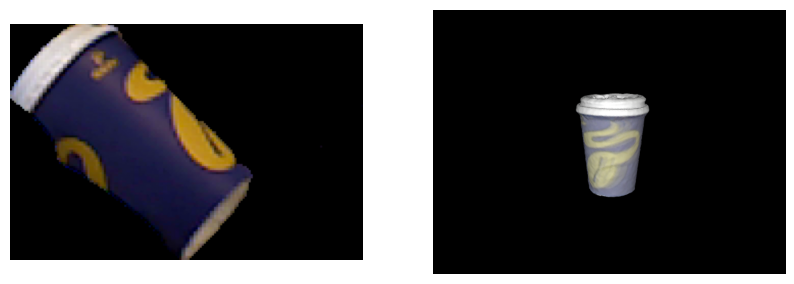

Dissimilarity score: tensor([0.1429])


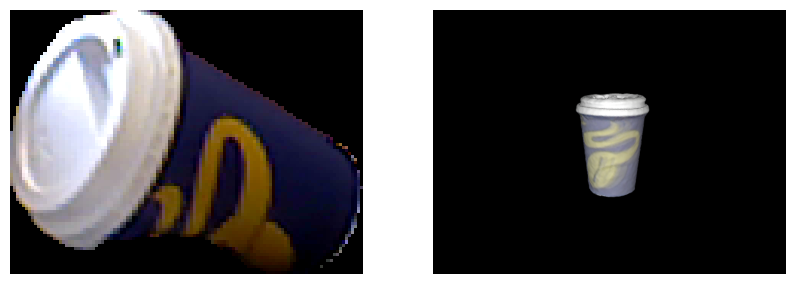

In [7]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn

from src.model.constrastive_learning import ContrastiveLoss, ContrastiveModel, resize_and_pad_image


transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ]
    )

model = ContrastiveModel(device)
model.load_state_dict(torch.load("contrastive_learning/saved_checkpoints/best_model_checkpoint.pth"))
model = model.to(device)
criterion = ContrastiveLoss()

temp_template = np.array(Image.open("datasets/bop23_challenge/datasets/templates_pyrender/icbin/obj_000001/000108.png"))[:,:,:3]/255.0
img2 = resize_and_pad_image(transform(temp_template), target_max=224).unsqueeze(0).float().to(device)

for i, proposal in enumerate(pos[20:45]):
    proposal = np.array(proposal["rgb"])
    # plt.imshow(proposal)
    # plt.axis('off')  # Optional: Turn off the axis
    # plt.show()

    img1 = resize_and_pad_image(transform(proposal), target_max=224).unsqueeze(0).float().to(device)
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        
        output1_test, output2_test = model(img1), model(img2)
        
        euclidean_distance = nn.functional.pairwise_distance(output1_test, output2_test).cpu().detach()
        
        print(f"Dissimilarity score: {euclidean_distance}")
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(proposal)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(temp_template)
        plt.axis('off')

        plt.show()
        # neg_class = criterion(output1_test, output2_test, 0)
        # pos_class = criterion(output1_test, output2_test, 1)
        
        # print(f"neg_class : {neg_class}, pos_class: {pos_class}")
        # if neg_class>0.5 and pos_class>0.5:
        #     print(" Not able to identify - wrong case")
        # if neg_class<0.5 and pos_class<0.5:
        #     print(" Not able to identify - wrong case")
        # elif neg_class>0.5:
        #     print("proposal is negative")
        # elif pos_class>0.5:
        #     print("proposal is positive")

index 0


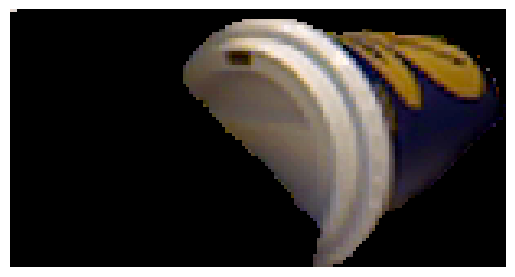

index 1


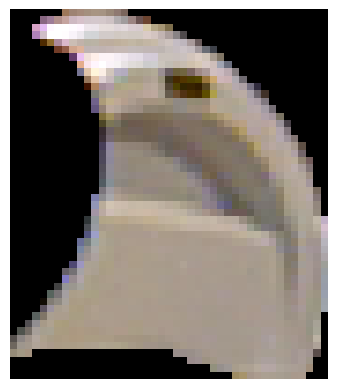

index 2


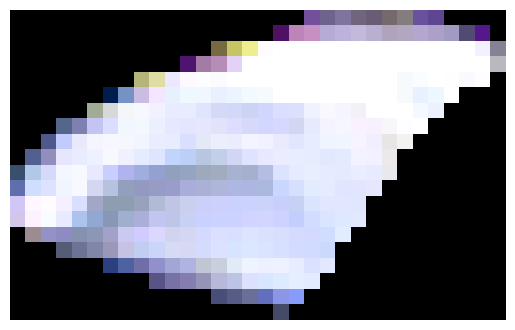

index 3


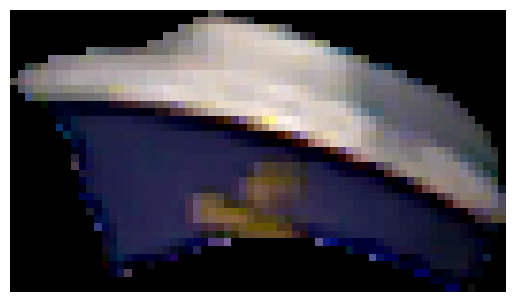

index 4


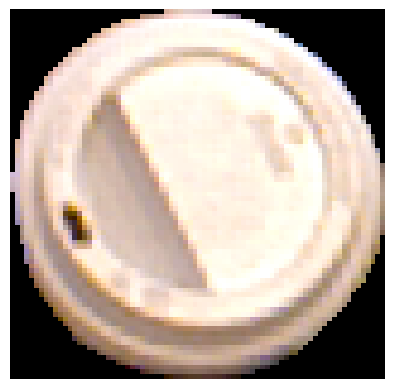

index 5


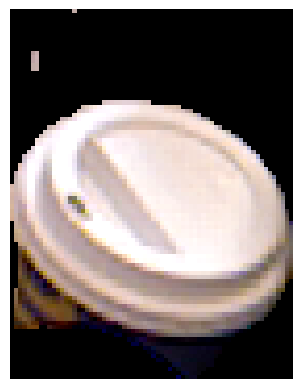

index 6


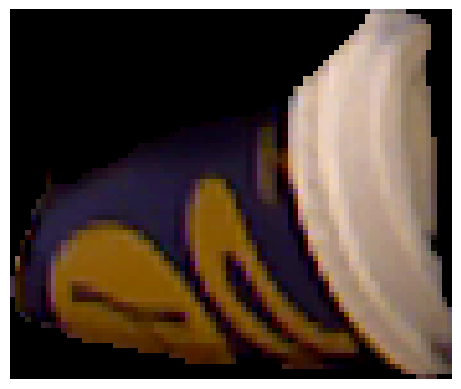

index 7


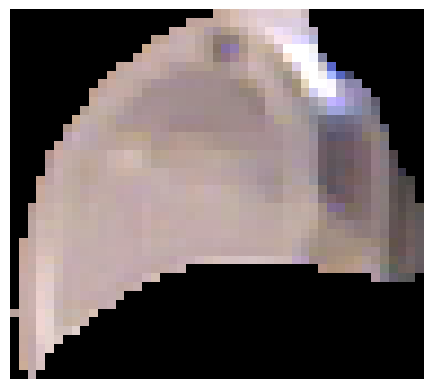

index 8


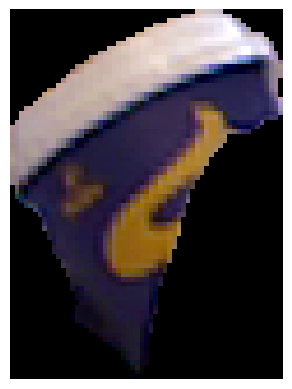

index 9


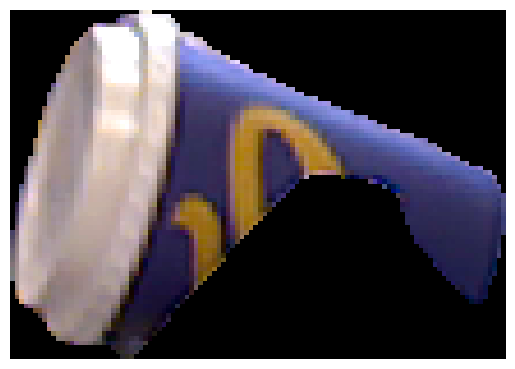

index 10


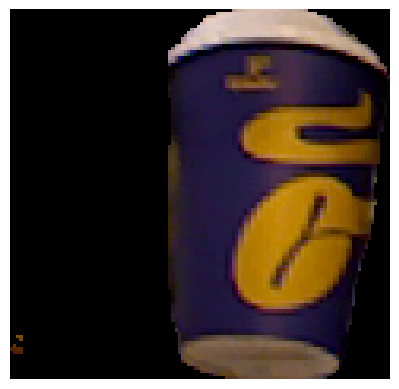

index 11


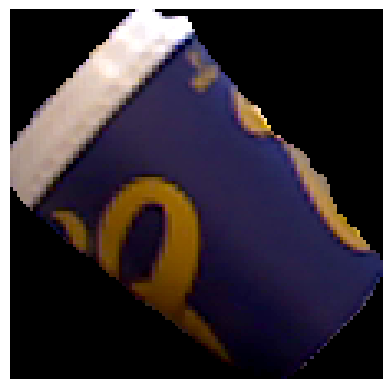

index 12


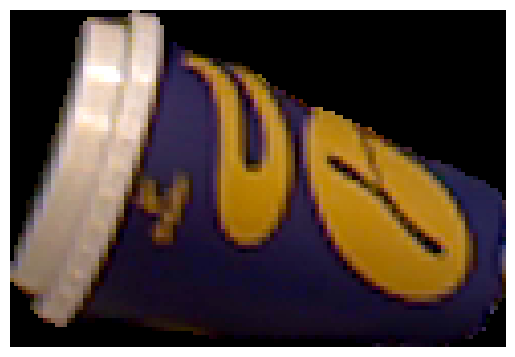

index 13


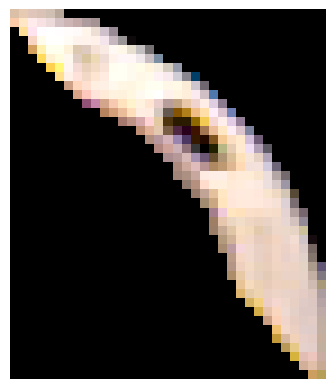

index 14


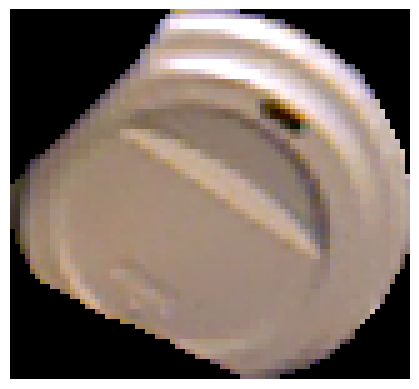

index 15


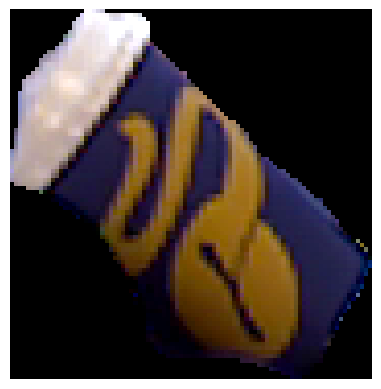

index 16


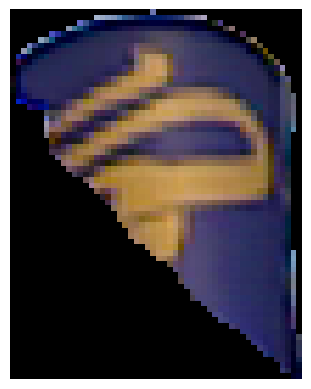

index 17


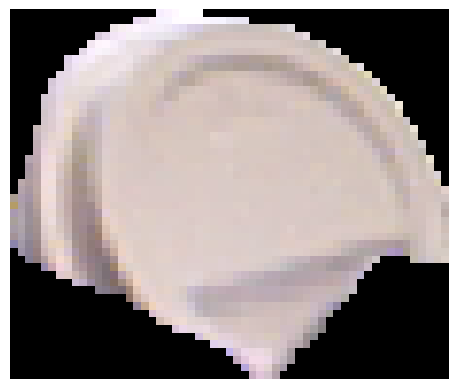

index 18


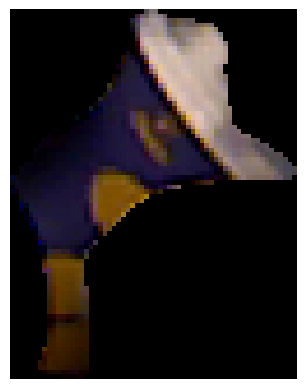

index 19


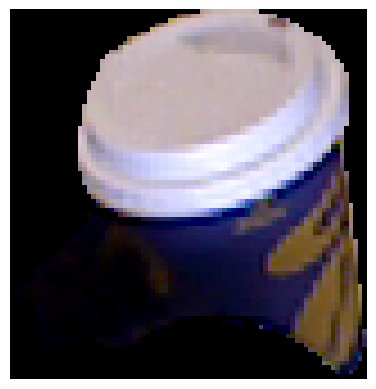

index 20


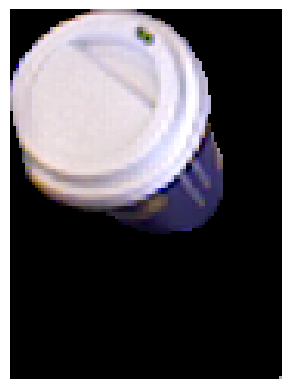

index 21


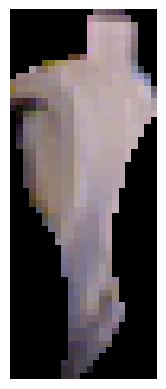

index 22


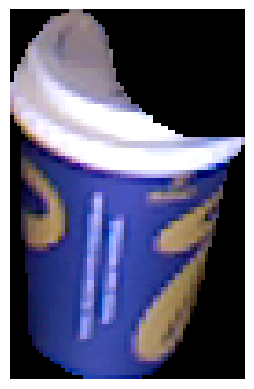

index 23


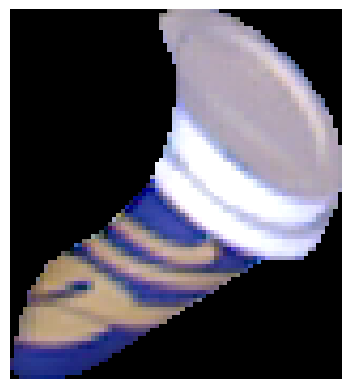

index 24


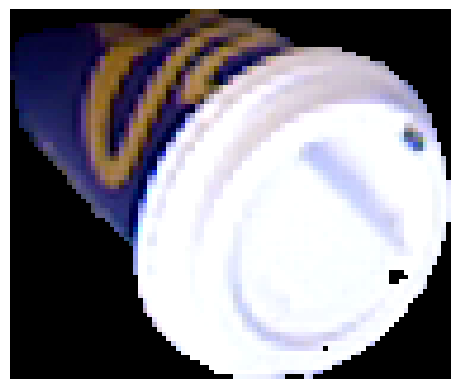

index 25


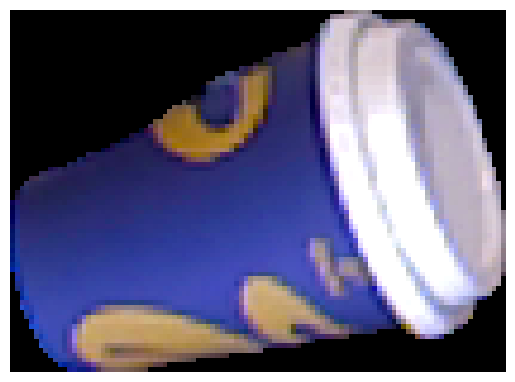

index 26


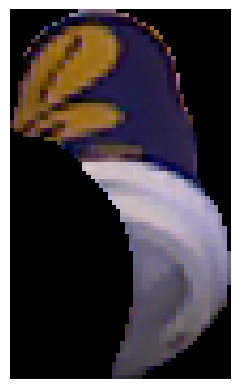

index 27


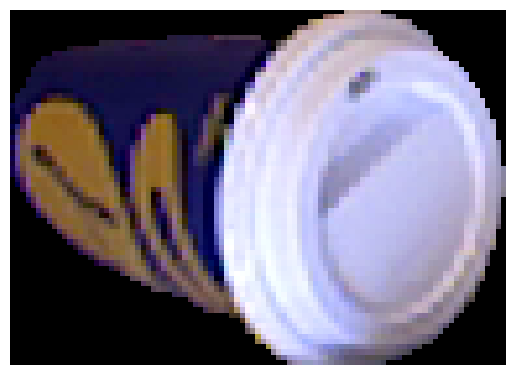

index 28


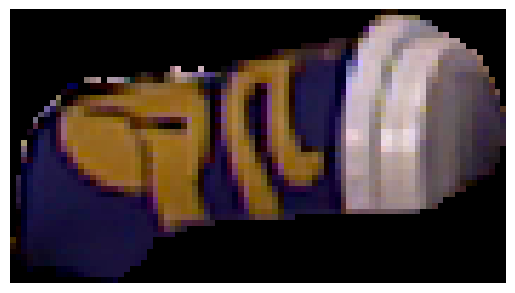

index 29


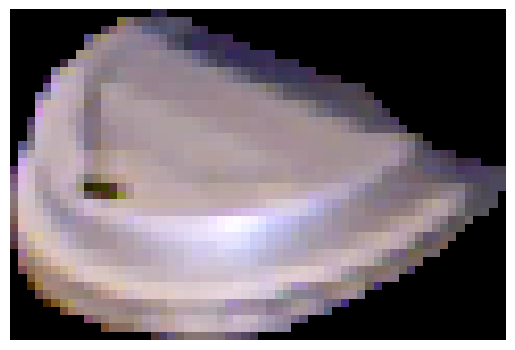

index 30


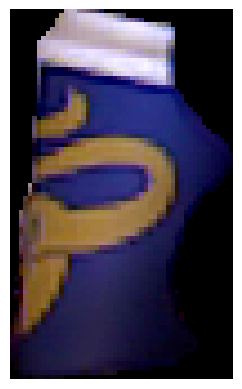

index 31


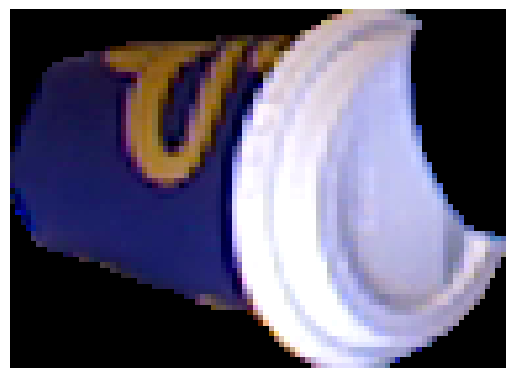

index 32


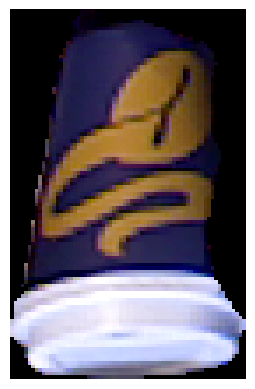

index 33


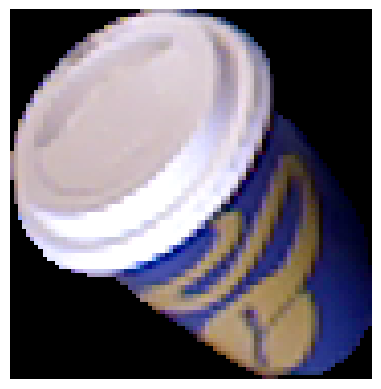

index 34


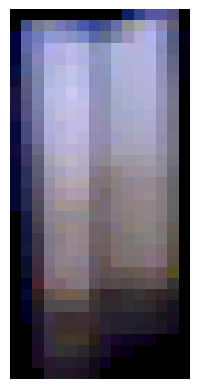

index 35


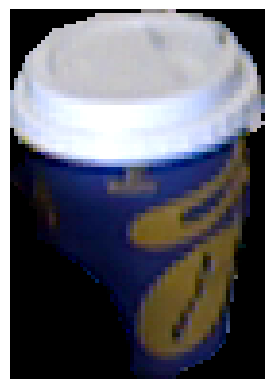

index 36


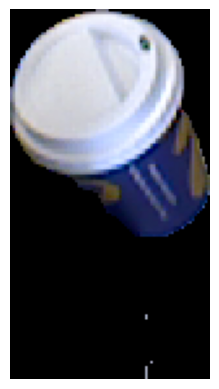

index 37


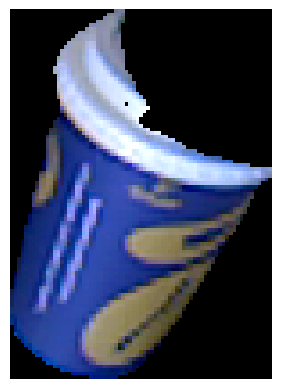

index 38


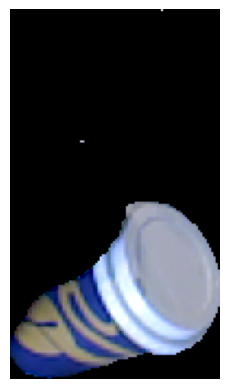

index 39


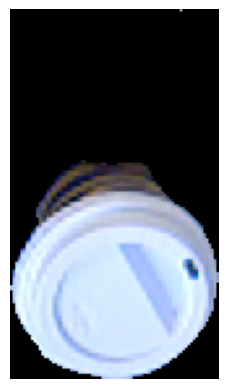

index 40


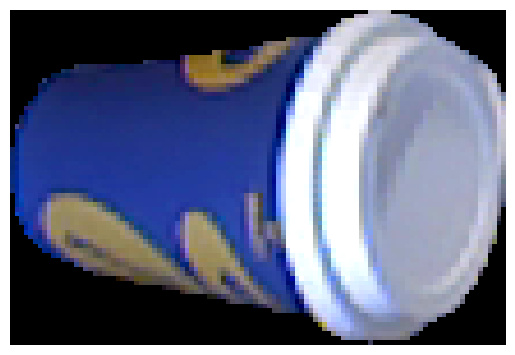

index 41


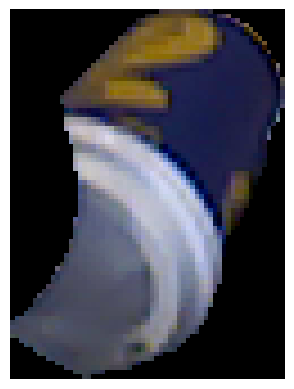

index 42


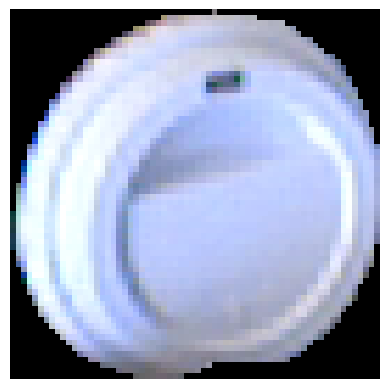

index 43


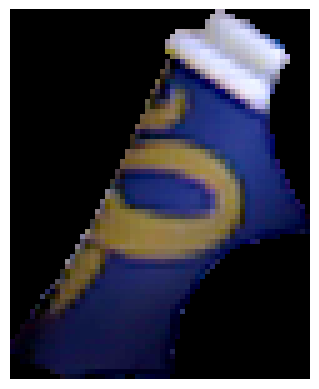

index 44


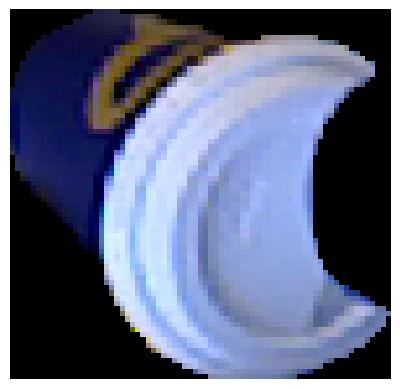

In [62]:
for i, proposal in enumerate(pos[45:90]):
    proposal = np.array(proposal["rgb"])
    print("index", i)
    plt.imshow(proposal)
    plt.axis('off')  # Optional: Turn off the axis
    plt.show()

In [48]:
neg_class = criterion(output1_test, output2_test, 0)
pos_class = criterion(output1_test, output2_test, 1)

In [51]:
neg_class

tensor(0.6837, device='cuda:0')

In [35]:
# import matplotlib.pyplot as plt
# plt.imshow(templates["rgb"][0])
# template_paths

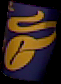

In [102]:
all_neg_proposals[2]

# 2. Process dataset
Build train_dataset as postive, negative pairs
Then build train_loader

Organize your images into classes. You'll need positive pairs (same class) and negative pairs (different classes) for training.
Resize/pad image to 224*224  then /255.0
then transform the image (also with std, mean as in ImageNet)

In [ ]:
from src.model.constrastive_learning import PairedDataset

# Custom dataset for paired images

# 3. Model

Two Approaches

    Extract features from Dinov2 as in cnos
    
    Extract BoW vectors as in FoundPose


# 4. Implement contrastive loss function


# 5. Create data pairs for training


# 6. Train the model

# 7. Nhap

In [ ]:
# def pose_similarity(given_pose, poses):
#     R_given, t_given = np.array(given_pose[:3, :3]), np.array(given_pose[:3, 3])
#     similarities = []

#     for idx, pose in enumerate(poses):
#         R, t = np.array(pose[:3, :3]), np.array(pose[:3, 3])
        
#         # Calculate Euclidean distance for translation
#         translation_dist = np.linalg.norm(t_given - t)
        
#         # Calculate Frobenius norm for rotation
#         rotation_dist = np.linalg.norm(R_given - R, ord='fro')

#         # Total similarity measure (you can adjust the weights if needed)
#         total_dist = translation_dist + rotation_dist
#         similarities.append((total_dist, idx))

#     # Sort by similarity (lower distance means more similar)
#     similarities.sort()

#     return similarities

# given_pose = pos_proposals[0][0]["pose"]
# poses = templates["poses"]
# similarity_scores = pose_similarity(given_pose, poses)
# top_5_similar = similarity_scores[:5]

In [ ]:
# from scipy.spatial.distance import cdist
# from scipy.spatial.transform import Rotation
# import matplotlib.pyplot as plt

# def compute_inplane(rot_query_openCV, rot_template_openCV):
#     delta = rot_template_openCV.dot(rot_query_openCV.T)
#     inp = extract_inplane_from_pose(delta)
#     # double check to make sure that reconved rotation is correct
#     R_inp = convert_inplane_to_rotation(inp)
#     recovered_R1 = R_inp.dot(rot_template_openCV)
#     err = geodesic_numpy(recovered_R1, rot_query_openCV)
#     if err >= 15:
#         print("WARINING, error of recovered pose is >=15, err=", err)
#     return inp

# def opencv2opengl(cam_matrix_world):
#     transform = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
#     if len(cam_matrix_world.shape) == 2:
#         return np.matmul(transform, cam_matrix_world)
#     else:
#         transform = np.tile(transform, (cam_matrix_world.shape[0], 1, 1))
#         return np.matmul(transform, cam_matrix_world)

# def extract_inplane_from_pose(pose):
#     inp = Rotation.from_matrix(pose).as_euler("zyx", degrees=True)[0]
#     return inp

# def convert_inplane_to_rotation(inplane):
#     R_inp = Rotation.from_euler("z", -inplane, degrees=True).as_matrix()
#     return R_inp

# def geodesic_numpy(R1, R2):
#     theta = (np.trace(R2.dot(R1.T)) - 1) / 2
#     theta = np.clip(theta, -1, 1)
#     return np.degrees(np.arccos(theta))

# def extract_positive_pairs(all_pos_proposals)
#     pos_pairs = list()
#     for proposals_id in range(len(all_pos_proposals)):
#         obj_query_pose = all_pos_proposals[proposals_id]["pose"][None]
#         obj_template_poses = templates["poses"]

#         return_inplane = True

#         obj_query_openGL_pose = opencv2opengl(obj_query_pose)
#         obj_query_openGL_location = obj_query_openGL_pose[:, 2, :3]  # Mx3 # (translation components) -  It assumes that the 3D location is found in the third column of the pose matrices.
#         obj_template_openGL_poses = opencv2opengl(obj_template_poses)
#         obj_template_openGL_locations = obj_template_openGL_poses[:, 2, :3]  # Nx3 # (translation components)

#         # find the nearest template
#         # It computes the pairwise distances between each query pose location and each template pose location using cdist.
#         distances = cdist(obj_query_openGL_location, obj_template_openGL_locations)
#         best_index_in_pose_distribution = np.argmin(distances, axis=-1)  # M
#         if return_inplane:
#             nearest_poses = obj_template_poses[best_index_in_pose_distribution]
#             inplanes = np.zeros(len(obj_query_pose))
#             for idx in range(len(obj_query_pose)):
#                 rot_query_openCV = obj_query_pose[idx, :3, :3]
#                 rot_template_openCV = nearest_poses[idx, :3, :3]
#                 inplanes[idx] = compute_inplane(rot_query_openCV, rot_template_openCV)
#         #     return self.avail_index[best_index_in_pose_distribution], inplanes #  self.avail_index is just the index from 0 to 42

#         pos_pair = {
#             "img1" : templates["rgb"][best_index_in_pose_distribution[0]],
#             "img2" : all_pos_proposals[proposals_id]["rgb"],
#             "label" : 1
#         }
#         pos_pairs.append(pos_pair)
#         # plt.figure(figsize=(10, 5))
#         # plt.subplot(1, 2, 1)
#         # plt.imshow(templates["rgb"][best_index_in_pose_distribution[0]])
#         # plt.axis('off')

#         # plt.subplot(1, 2, 2)
#         # plt.imshow(all_pos_proposals[proposals_id]["rgb"])
#         # plt.axis('off')

#         # plt.show()
#     return pos_pairs